# Аппроксимации граничных условий второго рода в методе конечных разностей на примере уравнения теплопроводности

In [1]:
import random
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits import mplot3d
from matplotlib import cm
from prettytable import PrettyTable

In [2]:
x, t = sp.symbols('x t')

## Общая постановка задачи

Дано следующее уравнение:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}  + f(x), x \in [a, b], t \in [0, T]
$$

Зададим оператор $L$:

$$
L = \frac{\partial}{\partial t} - \frac{\partial^2}{\partial x^2}
$$

Для аппроксимации оператора $L$ с помощью явной схемы используем следующие точки:

![](https://refdb.ru/images/1449/2896254/4b092928.png)

Обозначим для удобства точки следующим образом:

$$
x_{j,k} = (x, t)
$$

Тогда, обозначив разность 
$$x_{j,k}-x_{j-1, k} = h$$
A
$$x_{j,k+1}-x_{j,k}=\tau$$

Получаем:

$$
x_{j-1, k} = (x - h, t)
$$
$$x_{j+1, k} = (x + h, t)
$$
$$
x_{j, k + 1} = (x, t + \tau)
$$
Используя эти точки можем аппроксимировать функции

### 1. Явная схема

$$
\frac{\partial u}{\partial t} = \frac{u(x, t + \tau) - u(x, t)}{\tau}
$$

$$
\frac{\partial^2 u}{\partial x^2} = \frac{u(x+h, t) - 2u(x, t) + y(x-h, t)}{h^2}
$$

Таким образом результат оператора $Lu$:

$$
Lu = \frac{u(x, t + \tau) - u(x, t)}{\tau} - \frac{u(x+h, t) - 2u(x, t) + y(x-h, t)}{h^2}
$$

Теперь давайте выразим отсюда $u(x, t + \tau)$:

$$
u(x, t + \tau) = u(x, t) + \tau(\frac{u(x + h, t)}{h^2} - 2 \frac{u(x, t)}{h^2} + \frac{u(x-h, t)}{h^2})
$$

### Итого приведя слагаемые:

$$
u(x, t + \tau) = \frac{\tau}{h^2}u(x-h,t) + (1 - \frac{2\tau}{h^2})u(x,t) + \frac{\tau}{h^2}u(x+h, t)
$$ 

#### Что в итоге?

Зная значения из нижниго слоя, можно найти значения на верхнем слое

### 2. Неявная схема

$$
\frac{\partial u}{\partial t} = \frac{u(x, t + \tau) - u(x, t)}{\tau}
$$

$$
\frac{\partial^2 u}{\partial x^2} = \frac{u(x+h, t + \tau) - 2u(x, t + \tau) + y(x-h, t + \tau)}{h^2}
$$

Таким образом результат оператора $Lu$:

$$
Lu = \frac{u(x, t + \tau) - u(x, t)}{\tau} - \frac{u(x+h, t+\tau) - 2u(x, t+\tau) + y(x-h, t+\tau)}{h^2}
$$

Теперь давайте выразим отсюда $u(x, t)$:

$$
u(x, t) = u(x, t + \tau) - \tau(\frac{u(x + h, t+\tau)}{h^2} + 2 \frac{u(x, t+\tau)}{h^2} - \frac{u(x-h, t+\tau)}{h^2})
$$

### Итого приведя слагаемые:

$$
u(x, t) = -\frac{\tau}{h^2}u(x-h,t+\tau) + (1 + \frac{2\tau}{h^2})u(x,t+\tau) - \frac{\tau}{h^2}u(x+h, t+\tau)
$$ 

In [3]:
def plot_3d(xs, ts, Z):
    X, Y = np.meshgrid(xs, ts)
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    # surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=2)
    
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()

In [4]:
def plot_2d(xs, matrix_ys, step):
    for i in range(0, len(matrix_ys), step):
        plt.plot(xs, matrix_ys[i])
    
    plt.grid()
    plt.show()

# 1. Явная схема

In [5]:
# initial condition
a, b = 0, 1
k = 1
T = 0.05
# steps size
h_x = 0.02
h_t = 0.5 * h_x**2 / k
# expression of initial function
phi_expr = 0
g1_expr = 0
g2_expr = 0
f_expr = x
# initial functions
phi = sp.lambdify(x, phi_expr)
g1 = sp.lambdify(t, g1_expr)
g2 = sp.lambdify(t, g2_expr)
f = sp.lambdify((x, t), f_expr)

### Формула для явной схема с учётом константы:

$$
u(x, t + \tau) = \frac{c \cdot \tau}{h^2}u(x-h,t) + (1 - \frac{c \cdot \tau}{h^2})u(x,t) + \frac{c \cdot \tau}{h^2}u(x+h, t) + \tau f(x), c - const
$$

#### Первый метод

Правое краевое условие задано следующим образом:

$$
\frac{\partial u}{\partial x}(b, t) = g_2(t)
$$

Для первого метода правое краевое условие будем аппроксимировать по формуле:

$$
\frac{\partial T}{\partial x} = \frac{T_N^n - T_{n-1}^n}{h}
$$

Таким образом:

$$
T_N^n = h g_2(t) + T_{N-1}^n
$$

In [6]:
def explicit_method(a, b, k, T, phi, g1, g2, f, h_x, h_t):
    hx_step_amount = int((b - a) / h_x)
    ht_step_amount = int(T / h_t)
    
    h_x = (b - a) / hx_step_amount
    h_t = T / ht_step_amount
    
    h_xs = np.linspace(a, b, hx_step_amount)
    h_ts = np.linspace(0, T, ht_step_amount)
    
    matrix = np.zeros(shape=(ht_step_amount, hx_step_amount))
    
    matrix[0, 1:-1] = np.array([phi(hs) for hs in h_xs[1:-1]])
    matrix[:, 0] = np.array([g1(ht) for ht in h_ts])
#     matrix[:, -1] = np.array([g2(h_ts[i]) * h_t + matrix[i-1, -1] for i in range(len(h_ts))])
    
    coefs = [
        k * h_t / h_x**2,
        1 - 2 * k * h_t / h_x**2,
        k * h_t / h_x**2,
    ]
    
    for i in range(1, ht_step_amount):
        prev_layer = matrix[i - 1]
        matrix[i, 1: -1] = (
            sum(coefs[i] * prev_layer[i:len(prev_layer)-2+i] for i in range(3)) # sum yn-1 yn yn+1
            + np.array([h_t * f(hx, h_ts[i-1]) for hx in h_xs[1:-1]]) # vector of tau * f(x, t)
        )
        matrix[i, -1] = matrix[i, -2] + h_x * g2(h_ts[i])
    
#     plot_2d(h_xs, matrix, 5)
#     plot_3d(h_xs, h_ts, matrix)
    
    return matrix

In [7]:
exp_res1 = explicit_method(a, b, k, T, phi, g1, g2, f, h_x, h_t)

#### Второй способ

Правое граничное условие будем аппроксимировать по обычной формуле при помощи добавления фиктивных узлов. Для этого аппроксимируем граничное условие следующим образом:

$$
\frac{\partial T}{\partial x} = \frac{T_{N + 1}^n - T_{N-1}^n}{2h}
$$

Отсюда выразим фиктивный узел:

$$
T_{N+1}^n = 2h g_2(t) + T_{N-1}^n
$$

Подставив это в нашу исходную формулу получим:

$$
u(b, t + \tau) = \frac{c \cdot \tau}{h^2}u(b-h,t) + (1 - \frac{c \cdot \tau}{h^2})u(b,t) + \frac{c \cdot \tau}{h^2}(
2h g_2(t) + T_{N-1}^n) + \tau f(x), c - const
$$

In [8]:
def explicit_method_2(a, b, k, T, phi, g1, g2, f, h_x, h_t):
    hx_step_amount = int((b - a) / h_x) + 1
    ht_step_amount = int(T / h_t) + 1
    
    h_xs = np.linspace(a, b, hx_step_amount)
    h_ts = np.linspace(0, T, ht_step_amount)
    
    matrix = np.zeros(shape=(ht_step_amount, hx_step_amount))
    
    matrix[0, 1:-1] = np.array([phi(hs) for hs in h_xs[1:-1]])
    matrix[:, 0] = np.array([g1(ht) for ht in h_ts])
#     matrix[:, -1] = np.array([g2(h_ts[i]) * h_t + matrix[i-1, -1] for i in range(len(h_ts))])
    
    coefs = [
        k * h_t / h_x**2,
        1 - 2 * k * h_t / h_x**2,
        k * h_t / h_x**2,
    ]
    
    for i in range(1, ht_step_amount):
        prev_layer = matrix[i - 1]
        matrix[i, 1: -1] = (
            sum(coefs[i] * prev_layer[i:len(prev_layer)-2+i] for i in range(3)) # sum yn-1 yn yn+1
            + np.array([h_t * f(hx, h_ts[i-1]) for hx in h_xs[1:-1]]) # vector of tau * f(x, t)
        )
        matrix[i, -1] = (2 * coefs[0] * matrix[i-1, -2] 
                         + coefs[1] * matrix[i-1, -1] 
                         + h_t * f(b, h_ts[i])
                         + 2 * h_x * coefs[0] * g2(h_ts[i]))
    
    plot_2d(h_xs, matrix, 5)
    plot_3d(h_xs, h_ts, matrix)
    
    return matrix

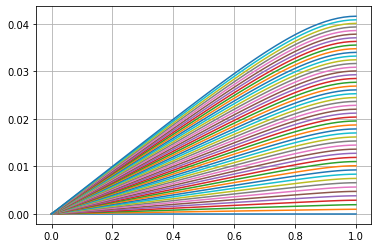

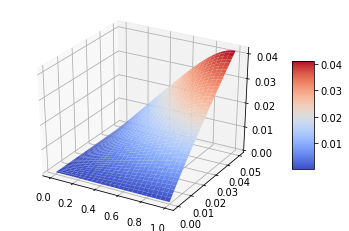

In [9]:
exp_res2 = explicit_method_2(a, b, k, T, phi, g1, g2, f, h_x, h_t)

# 2. Неявная схема

Для каждой строки матрицы (кроме первой - заполняется начальным условием) необходимо решить систему линейных уравнений (каждый текущий член, зависит от следующего):

$$
u(x, t) + \tau f(t) = -\frac{с\tau}{h^2}u(x-h,t+\tau) + (1 + \frac{2c\tau}{h^2})u(x,t+\tau) - \frac{c\tau}{h^2}u(x+h, t+\tau)
$$ 

$c = const$

Таким образом для нахождения решения можно заполнить матрицу коэффициентов и затем на каждом новом временном слое находить новый вектор свободных членов, т.е матрица будет иметь вид:

$ 1 0 .... $

$ k_1 k_2 k_3 ....$

$ 0 k_1 k_2 k_3 ...$

............

$ 0 ...... -1 1$'

Взависимости от способа будут отличаться последние строки в нашей матрице коэффициентов и векторе свободных членов

In [10]:
# initial condition
a, b = 0, 1
k = 1
T = 0.05
# steps size
h_x = 0.02
h_t = 0.5 * h_x**2 / k
# expression of initial function
phi_expr = 0
g1_expr = 0
g2_expr = 0
f_expr = x
# initial functions
phi = sp.lambdify(x, phi_expr)
g1 = sp.lambdify(t, g1_expr)
g2 = sp.lambdify(t, g2_expr)
f = sp.lambdify((x, t), f_expr)

$$
u(x, t) + \tau f(t)= -\frac{с\tau}{h^2}u(x-h,t+\tau) + (1 + \frac{2c\tau}{h^2})u(x,t+\tau) - \frac{c\tau}{h^2}u(x+h, t+\tau)
$$ 
$c = const$

#### Первый способ

Правое краевое условие задано следующим образом:

$$
\frac{\partial u}{\partial x}(b, t) = g_2(t)
$$

Для первого метода правое краевое условие будем аппроксимировать по формуле:

$$
\frac{\partial T}{\partial x} = \frac{T_N^n - T_{n-1}^n}{h}
$$

Таким образом:

$$
 - T_{N-1}^n + T_N^n= h g_2(t)
$$

Таким образом коэффициенты в последней строке матрицы коэффициентов $-1, 1$, а в векторе свободных членов последний элемент $=hg_2(t)$ 

In [11]:
def implicit_method(a, b, k, T, phi, g1, g2, f, h_x, h_t):
    hx_step_amount = int((b - a) / h_x) + 1
    ht_step_amount = int(T / h_t) + 1
    
    h_xs = np.linspace(a, b, hx_step_amount)
    h_ts = np.linspace(0, T, ht_step_amount)
    
    matrix = np.zeros(shape=(ht_step_amount, hx_step_amount))
    
    matrix[0, 1:-1] = np.array([phi(hs) for hs in h_xs[1:-1]])
    matrix[:, 0] = np.array([g1(ht) for ht in h_ts])
    matrix[:, -1] = np.array([g2(ht) * h_t for ht in h_ts])
    
    coefs = [
        -k * h_t / h_x**2,
        1 + 2 * k * h_t / h_x**2,
        -k * h_t / h_x**2,
    ]
    
    coefs_matrix = np.zeros(shape=(hx_step_amount, hx_step_amount))
    # fill coefs matrix
    np.fill_diagonal(coefs_matrix, coefs[1])
    np.fill_diagonal(coefs_matrix[1:], coefs[0])
    np.fill_diagonal(coefs_matrix[:, 1:], coefs[2])
    # fill border condition coefs matrix
    coefs_matrix[0, 0] = 1
    coefs_matrix[0, 1] = 0
    coefs_matrix[-1, -2] = -1
    coefs_matrix[-1, -1] = 1
    
    
    for i in range(1, ht_step_amount):
        rhs = np.array([h_t * f(hx, h_ts[i]) for hx in h_xs]) + matrix[i-1]
        rhs[0] = g1(h_ts[i])
        rhs[-1] = h_x * g2(h_ts[i])
        matrix[i] = np.linalg.solve(coefs_matrix, rhs)
        
    plot_2d(h_xs, matrix, 5)
    plot_3d(h_xs, h_ts, matrix)
    
    return matrix

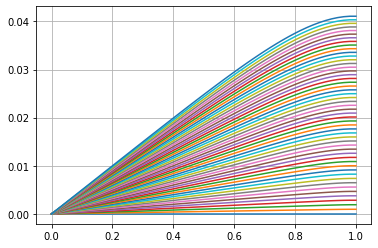

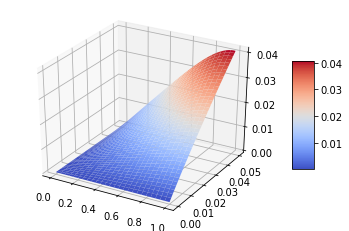

In [12]:
imp_res1 = implicit_method(a, b, k, T, phi, g1, g2, f, h_x, h_t)

#### Второй способ

Правое граничное условие будем аппроксимировать по обычной формуле при помощи добавления фиктивных узлов. Для этого аппроксимируем граничное условие следующим образом:

$$
\frac{\partial T}{\partial x} = \frac{T_{N + 1}^n - T_{N-1}^n}{2h}
$$

Отсюда выразим фиктивный узел:

$$
T_{N+1}^n = 2h g_2(t) + T_{N-1}^n
$$

Подставив это в нашу исходную формулу получим:

$$
-\frac{2c \cdot \tau}{h^2}u(b-h,t) + (1 + \frac{c \cdot \tau}{h^2})u(b,t) = -\frac{c \cdot \tau}{h^2}
2h g_2(t) + \tau f(x) + u(b, t), c - const
$$

Отсюда соответственно и берём последнюю строку для матрицы коэффициентов и последний элемент в матрице свободных членов

In [13]:
def implicit_method_2(a, b, k, T, phi, g1, g2, f, h_x, h_t):
    hx_step_amount = int((b - a) / h_x) + 1
    ht_step_amount = int(T / h_t) + 1
    
    h_xs = np.linspace(a, b, hx_step_amount)
    h_ts = np.linspace(0, T, ht_step_amount)
    
    matrix = np.zeros(shape=(ht_step_amount, hx_step_amount))
    
    matrix[0, 1:-1] = np.array([phi(hs) for hs in h_xs[1:-1]])
    matrix[:, 0] = np.array([g1(ht) for ht in h_ts])
    matrix[:, -1] = np.array([g2(ht) * h_t for ht in h_ts])
    
    coefs = [
        -k * h_t / h_x**2,
        1 + 2 * k * h_t / h_x**2,
        -k * h_t / h_x**2,
    ]
    
    coefs_matrix = np.zeros(shape=(hx_step_amount, hx_step_amount))
    # fill coefs matrix
    np.fill_diagonal(coefs_matrix, coefs[1])
    np.fill_diagonal(coefs_matrix[1:], coefs[0])
    np.fill_diagonal(coefs_matrix[:, 1:], coefs[2])
    # fill border condition coefs matrix
    coefs_matrix[0, 0] = 1
    coefs_matrix[0, 1] = 0
    coefs_matrix[-1, -2] = 2 * coefs[0]
#     coefs_matrix[-1, -1] =
    
    # rhs = np.zeros(shape=(1, hx_step_amount))
    
    
    for i in range(1, ht_step_amount):
        rhs = np.array([h_t * f(hx, h_ts[i]) for hx in h_xs]) + matrix[i-1]
        rhs[0] = g1(h_ts[i])
        rhs[-1] += -2 * h_x * coefs[0] * g2(b) 
        matrix[i] = np.linalg.solve(coefs_matrix, rhs)
        
    plot_2d(h_xs, matrix, 5)
    plot_3d(h_xs, h_ts, matrix)
    
    return matrix

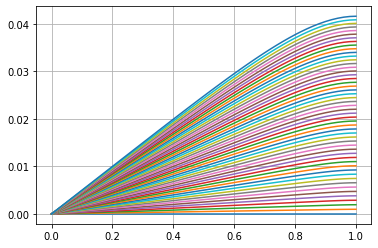

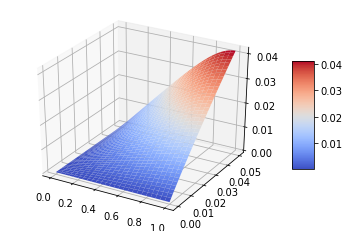

In [14]:
imp_res2 = implicit_method_2(a, b, k, T, phi, g1, g2, f, h_x, h_t)

# Результаты расчётов

#### Примечание

В реализацию построения таблиц не вникайте

### Начальные условия

In [15]:
# initial condition
a, b = 0, 1
k = 1
# expression of initial function
phi_expr = 0
g1_expr = 0
g2_expr = 0
f_expr = x
# initial functions
phi = sp.lambdify(x, phi_expr)
g1 = sp.lambdify(t, g1_expr)
g2 = sp.lambdify(t, g2_expr)
f = sp.lambdify((x, t), f_expr)
T = 0.5

In [16]:
mantissa_len = 10

### Fix $\tau$

In [17]:
# standard deviation
def SD_t(m1, m2, layer1, layer2):
    if len(m1[0]) > len(m2[0]):
        m1, m2 = m2, m1
        layer1, layer2 = layer2, layer1
    return np.sqrt(sum((m1[layer1][i] - m2[layer2][2*i])**2 for i in range(len(m1[0]))) / len(m1[0]))

In [18]:
def max_deviation_t(m1, m2, layer1, layer2):
    if len(m1[0]) > len(m2[0]):
        m1, m2 = m2, m1
        layer1, layer2 = layer2, layer1
    return max(np.abs([m1[layer1][i] - m2[layer2][2*i] for i in range(len(m1[0]))]))

In [19]:
Ns = np.array([5 * 2**i for i in range(4, -1, -1)])
Ns

array([80, 40, 20, 10,  5])

In [20]:
table_t = PrettyTable()

table_t.field_names = ['N : h', 'tau', 's(t=t_n1)', 's(t=t_n2)', 'max_abs(t=t_n1)', 'max_abs(t=t_n2)']

# select randomly t1 and t2
layer1 = random.randint(1, Ns[-1] - 1)
layer2 = random.randint(1, Ns[-1] - 1)

prev_res = None

print("t1 = {}, t2 = {}".format(T / Ns[-1] * layer1, T / Ns[-1] * layer2))

Xs = np.linspace(a, b, Ns[0] + 1)
tau = 0.5 * (Xs[1] - Xs[0])**2 / k

for i, N in enumerate(Ns):
    h_x = (b - a) / N
    res = explicit_method(a, b, T, k, phi, g1, g2, f, h_x, tau)
    if prev_res is None:
            table_t.add_row([Xs[1] - Xs[0], round(tau, mantissa_len), *list('-'*4)])
    else:
        # compute indexes of t1 and t2
        t11 = layer1 * Ns[i-1] // Ns[-1]
        t12 = layer1 * Ns[i] // Ns[-1]
        t21 = layer2 * Ns[i-1] // Ns[-1]
        t22 = layer2 * Ns[i] // Ns[-1]
        table_t.add_row(list(map(lambda x: round(x, mantissa_len),[
            h_x, 
            tau, 
            SD_t(prev_res, res, t11, t12), 
            SD_t(prev_res, res, t21, t22),
            max_deviation_t(prev_res, res, t11, t12),
            max_deviation_t(prev_res, res, t21, t22),
        ])))
    prev_res = res


print(table_t)

t1 = 0.30000000000000004, t2 = 0.30000000000000004
+--------+------------+--------------+--------------+-----------------+-----------------+
| N : h  |    tau     |  s(t=t_n1)   |  s(t=t_n2)   | max_abs(t=t_n1) | max_abs(t=t_n2) |
+--------+------------+--------------+--------------+-----------------+-----------------+
| 0.0125 | 7.8125e-05 |      -       |      -       |        -        |        -        |
| 0.025  | 7.8125e-05 | 0.0010593587 | 0.0010593587 |   0.0017998259  |   0.0017998259  |
|  0.05  | 7.8125e-05 | 0.0005229108 | 0.0005229108 |   0.0009178637  |   0.0009178637  |
|  0.1   | 7.8125e-05 | 0.0002573872 | 0.0002573872 |   0.0004679994  |   0.0004679994  |
|  0.2   | 7.8125e-05 | 0.0001318449 | 0.0001318449 |   0.0002404554  |   0.0002404554  |
+--------+------------+--------------+--------------+-----------------+-----------------+


### Fix $h$

In [21]:
# standard deviation
def SD_h(m1, m2, layer1, layer2):
    return np.sqrt(sum((m1[layer1][i] - m2[layer2][i])**2 for i in range(len(m1[0]))) / len(m1[0]))

In [22]:
def max_deviation_h(m1, m2, layer1, layer2):
    return max(np.abs([m1[layer1][i] - m2[layer2][i] for i in range(len(m1[0]))]))

In [23]:
Ts = np.array([100*2**i for i in range(5)])
Ts

array([ 100,  200,  400,  800, 1600])

In [24]:
table_h = PrettyTable()

table_h.field_names = ['N : h', 'tau', 's(t=t_n1)', 's(t=t_n2)', 'max_abs(t=t_n1)', 'max_abs(t=t_n2)']


max_tau = T / Ts[0]
h_x = np.sqrt(2 * k * max_tau)

# select randomly t1 and t2
layer1 = random.randint(1, Ts[0] - 1)
layer2 = random.randint(1, Ts[0] - 1)

prev_res = None

print("t1 = {}, t2 = {}".format(T / Ts[0] * layer1, T / Ts[0] * layer2))


for i, h_t in enumerate(Ts):
    tau = T / h_t
    res = explicit_method(a, b, T, k, phi, g1, g2, f, h_x, tau)
    if prev_res is None:
            table_h.add_row([h_x, round(tau, mantissa_len), *list('-'*4)])
    else:
        # compute indexes of t1 and t2
        t11 = layer1 * Ts[i-1] // Ts[0]
        t12 = layer1 * Ts[i] // Ts[0]
        t21 = layer2 * Ts[i-1] // Ts[0]
        t22 = layer2 * Ts[i] // Ts[0]
        table_h.add_row(list(map(lambda x: round(x, mantissa_len),[
            h_x, 
            tau, 
            SD_h(prev_res, res, t11, t12), 
            SD_h(prev_res, res, t21, t22),
            max_deviation_h(prev_res, res, t11, t12),
            max_deviation_h(prev_res, res, t21, t22),
        ])))
    prev_res = res
    

print(table_h)

t1 = 0.14, t2 = 0.365
+-------+-----------+--------------+--------------+-----------------+-----------------+
| N : h |    tau    |  s(t=t_n1)   |  s(t=t_n2)   | max_abs(t=t_n1) | max_abs(t=t_n2) |
+-------+-----------+--------------+--------------+-----------------+-----------------+
|  0.1  |   0.005   |      -       |      -       |        -        |        -        |
|  0.1  |   0.0025  | 0.0001360568 | 0.0002327611 |   0.0002070563  |   0.0003218624  |
|  0.1  |  0.00125  |  6.7758e-05  | 0.0001160068 |   0.0001031156  |   0.0001604545  |
|  0.1  |  0.000625 | 3.38117e-05  | 5.79104e-05  |   5.14549e-05   |   8.01086e-05   |
|  0.1  | 0.0003125 |  1.6889e-05  |  2.8932e-05  |   2.57017e-05   |   4.00247e-05   |
+-------+-----------+--------------+--------------+-----------------+-----------------+
